In [1]:
import numpy as np
from stdb import load_db 
import pygmt
import pandas as pd
import pickle
import glob, os
import warnings  
from obspy.core.event.catalog import read_events
warnings.filterwarnings("ignore")  

In [3]:
pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman',
            FONT_LABEL = '8',
            MAP_LABEL_OFFSET = '4p',
            MAP_TICK_LENGTH_PRIMARY = '5p',
#             PS_MEDIA ='A4',
            PROJ_LENGTH_UNIT = 'c',
            MAP_ANNOT_OFFSET_PRIMARY = '5p',
            MAP_ANNOT_OFFSET_SECONDARY = '5p',
            MAP_FRAME_TYPE = 'fancy',
            MAP_FRAME_WIDTH = 'auto',
            FORMAT_GEO_MAP = 'D',
            PS_CHAR_ENCODING = 'Standard+',
            MAP_FRAME_PEN = '2p,black')


def PygmtBegin(figmap, region,Volcano=True,OtherSKS=True):
    pygmt.makecpt(cmap="elevation", series=[0, 4000, 500],output = 'eleva.cpt', continuous=True)
    figmap.basemap(region=region, projection="M15c", frame = ['x1f0.5', 'y1f0.5', 'nSeW'])
    figmap.grdimage('@earth_relief_30s',region =region, cmap="eleva.cpt",monochrome=True, shading=True, transparency=50)
    figmap.coast(resolution = 'h', shorelines ='1/thinnest,black', water='white', borders = '1/0.8p')
##==========legned setting 
    figmap.plot(x=39.5,y=37.1,style="c0.4c", pen="1p,black", no_clip=True)
    figmap.text(x=39.5,y=36.9,text='Null', font="12p,Times-Bold,black", no_clip=True)
    RCdata = [[40.5, 37.1, 0, 5, 1*40]]
    SCdata = [[40.5, 36.9, 0, 5, 1*40]]
    figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.01p,black", no_clip=True)
    figmap.text(x=41,y=37.1,text='RC', font="12p,Times-Bold,black", no_clip=True)
    figmap.plot(data=SCdata, style="J", color="red3", pen="0.01p,black", no_clip=True)
    figmap.text(x=41,y=36.9,text='SC', font="12p,Times-Bold,black", no_clip=True)
    legenddata=[[42, 37.1, 0, 5, 0.5*40],[42.8, 37.1, 0, 5, 1*40],[43.8, 37.1, 0, 5, 1.5*40],[45,37.1,0,5,2*40]]
    figmap.plot(data=legenddata, style="J", color="black", pen="0.01p,black", no_clip=True)
    figmap.text(x=42,y=36.9,text='0.5s', font="12p,Times-Bold,black", no_clip=True)
    figmap.text(x=42.8,y=36.9,text='1s', font="12p,Times-Bold,black", no_clip=True)
    figmap.text(x=43.8,y=36.9,text='1.5s', font="12p,Times-Bold,black", no_clip=True)
    figmap.text(x=45,y=36.9,text='2s', font="12p,Times-Bold,black", no_clip=True)
    figmap.plot(x=46,y=37.0,style='kvolcano/0.5c',color='gold4',pen='0.5p,black', no_clip=True)
    figmap.text(x=46,y=36.75,text='Pleistocene', font="9p,Times-Bold,black", no_clip=True)
    figmap.plot(x=47,y=37.0,style='kvolcano/0.5c',color='gold2',pen='0.5p,black', no_clip=True)
    figmap.text(x=47,y=36.75,text='Holocene', font="9p,Times-Bold,black", no_clip=True) 
#     if Volcano:
    if OtherSKS:
        dt = pd.read_csv(Turkey,sep='\s+',names=['station','lat','lon','phi','stdphi','dt','stddt','num'])
        for t in range(len(dt)):
            if dt['lon'][t] > 39 and dt['lat'][t] >37 : 
                data = [[dt['lon'][t], dt['lat'][t], dt['phi'][t]-90, 3, dt['dt'][t]*40]]
                figmap.plot(data=data, style="J", color="grey47", pen="0.01p,black")
                figmap.plot(x=dt['lon'][t],y=dt['lat'][t],style="c0.15c",color='black', pen="white")
        dI = pd.read_csv(Iran,sep='\s+')
        for t in range(len(dI)):
            if dI['Longitude'][t] < 48 and dI['Latitude'][t] >37 and dI['FPD'][t] != '-': 
                data = [[dI['Longitude'][t], dI['Latitude'][t], float(dI['FPD'][t])-90, 3, float(dI['dt'][t])*40]]
                figmap.plot(data=data, style="J", color="Pink4", pen="0.01p,Pink4")
                figmap.plot(x=dI['Longitude'][t],y=dI['Latitude'][t],style="c0.15c",color='black', pen="white")
    
    figmap.text(textfiles='Countries.txt', font="16p,7,black",fill='white@30', justify ='LB', clearance='+tO')
    figmap.text(x=44.7,y=40.65,text='AM' ,font="14p,7,black",fill='white@30', justify ='LB', clearance='+tO')
    with pygmt.config(FONT_ANNOT_PRIMARY = '10p,Times-Roman', FONT_LABEL = '12p,Times-Bold',
                  MAP_ANNOT_OFFSET_PRIMARY = '0.2c', MAP_LABEL_OFFSET = '0.3c', 
                  MAP_TICK_LENGTH_PRIMARY = '0.2c', MAP_FRAME_PEN = '0.6p'): 
        figmap.colorbar(cmap = 'cmapDT.cpt', position = 'x0.5/14.3+w4c/0.2c+ml+h', frame = ['a0.5f0.2'])
        
    figmap.text(x=39.6,y=44.25,text='Splitting Time (s)', font="12p,Times-Bold,black", justify ='LB')
def Plot_event(figmap, Event):
    figmap.shift_origin(xshift = '10c', yshift = '9c')
    lat = 42; lon = 44
    colfill = '217.6/217.6/217.6'
    figmap.coast(region='g', 
              projection = f'E{lon}/{lat}/180/8c', 
              resolution = 'c', 
              land = colfill, 
              shorelines ='1/0.1p,' + colfill, 
              C = colfill, 
              frame = True)

    figmap.plot(x = lon, y = lat, style ='s0.6c', pen ='0.2', color = 'red')

    distlims = [60,90,120,150]
    for dists in distlims:
        figmap.plot(x = lon, y = lat, style ='E-' + str(2 * dists) + 'd', 
                 pen ='1p,black,3_1:0p',t = '60')

    figmap.text(x = 44, y = -20,  text = f'60@.', font='9p')
    figmap.text(x = 44, y = -48,  text = '90@.', font='9p')
    figmap.text(x = 44, y = -79,  text = '120@.', font='9p')
    figmap.text(x = -137, y = -71,   text = '150@.', font='9p')

    figmap.plot(x=Event['Lon'],y=Event['Lat'],
                sizes = np.exp(Event['Mag']/100)*0.52,
                color=Event['Dep'],cmap = 'cmapEQs.cpt' , style="a",pen="1p,black",transparency=40)

    with pygmt.config(FONT_ANNOT_PRIMARY = '12p,Times-Roman', FONT_LABEL = '15p,Times-Roman',
                      MAP_ANNOT_OFFSET_PRIMARY = '0.3c',
                      MAP_LABEL_OFFSET = '0.8c', 
                      MAP_TICK_LENGTH_PRIMARY = '0.2c',
                      MAP_FRAME_PEN = '0.6p'):    
        figmap.colorbar(cmap = 'cmapEQs.cpt', position = 'x9.5/0.55+w7c/0.4c+ml', frame = ['a100f50','+L"Depth (km)"'])    

In [6]:
PKLpath = '/Volumes/home/Research/STEP/01_Split'
Path = '/Volumes/home/Research/STEP/05_Station_result_statistics'
SAVEpath = '/Volumes/home/Research/STEP/06_CIA_SWS_result'

Volcano = '/Volumes/home/Research/DataBase/01_Armenia/02_Volcano_list.csv'
fault_1 = '/Volumes/home/Research/DataBase/01_Armenia/00_A_fault.txt'
fault_2 = '/Volumes/home/Research/DataBase/01_Armenia/00_Active_faults.txt'
fault_3 = '/Volumes/home/Research/DataBase/01_Armenia/00_ST_Fault_with_Sard.txt'
Turkey  = '/Volumes/home/Research/DataBase/02_SKS_splitting/Lemnifi_etal_Turkey_stations_averaged_DB.txt'
Iran    = '/Volumes/home/Research/DataBase/02_SKS_splitting/Arvin_etal_NW_Iran.txt'

notplotLIST = ['TRLG','BRNG','GUDG']
nodataLIST = ['SEAG','DGRG','BGLV']


YearRange = '2010-2020'
csvfile = f'Station_SKS_{YearRange}average_v2.csv'
ver=3

In [7]:
def Event_clean():
    Ori_Event = {'Time':[],
            'Lat':[],
            'Lon':[],
            'Mag':[],
            'Dep':[] }
    for evt in CATA:
        yyyy = str(evt.origins[0].time.year).zfill(4)
        mm   = str(evt.origins[0].time.month).zfill(2)
        dd   = str(evt.origins[0].time.day).zfill(2)
        hh   = str(evt.origins[0].time.hour ).zfill(2)
        mi   = str(evt.origins[0].time.minute).zfill(2)
        ss   = str(evt.origins[0].time.second).zfill(2)
        TIME = f'{yyyy}{mm}{dd}_{hh}{mi}{ss}'
        lat = evt.origins[0].latitude; lon = evt.origins[0].longitude
        mag = evt.magnitudes[0].mag
        dep = evt.origins[0].depth/1000
        Ori_Event['Time'].append(TIME)
        Ori_Event['Lat'].append(lat)
        Ori_Event['Lon'].append(lon)
        Ori_Event['Mag'].append(mag)
        Ori_Event['Dep'].append(dep)
    return Ori_Event

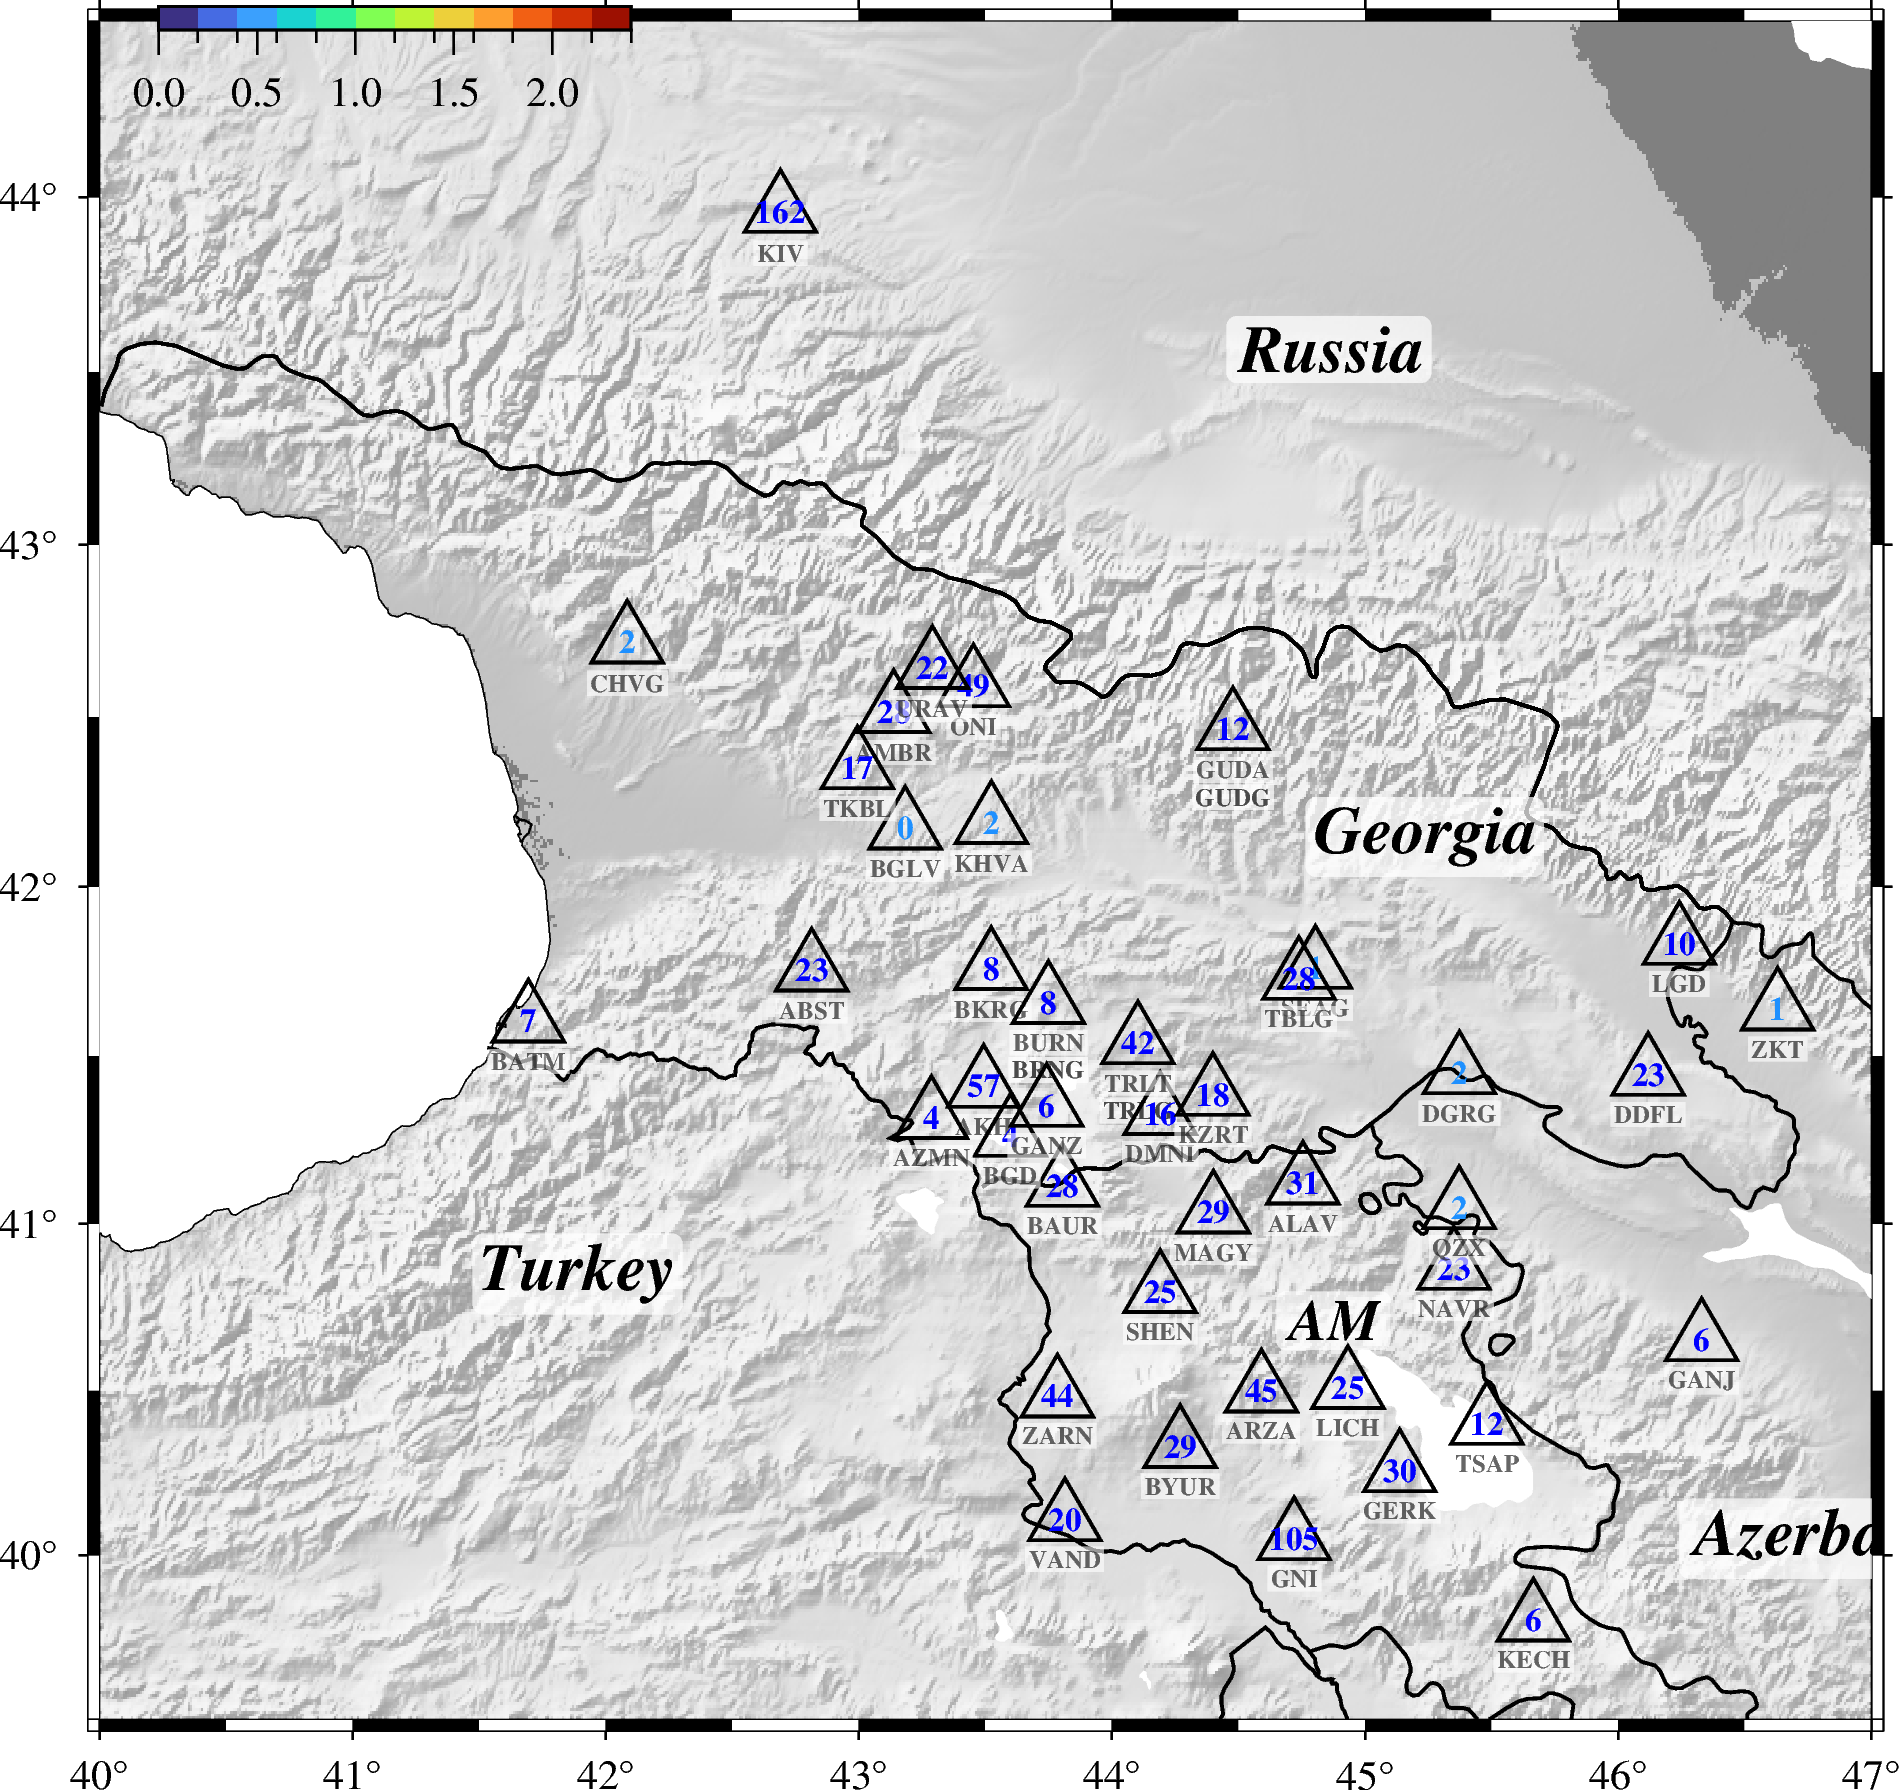

In [8]:

regvals = [40, 47, 39.5, 44.5]
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals, Volcano=False, OtherSKS=False)

df = pd.read_csv(f'{Path}/{csvfile}')
for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    NET = values['network']; STA = values['station']
    st_lat = values['latitude']; st_lon = values['longitude']
    NetSta = f'{NET}.{STA}'
#     print(NetSta)
    
    if STA == 'GUDA': 
        secondSTA = f'GO.GUDG'
        numSKS = df['Number'][df['Station']==NetSta].values[0] + df['Number'][df['Station']==secondSTA].values[0]
    elif STA == 'BURN':
        secondSTA = f'TG.BRNG'
        numSKS = df['Number'][df['Station']==NetSta].values[0] + df['Number'][df['Station']==secondSTA].values[0]
    elif STA == 'TRLT':
        secondSTA = f'GO.TRLG'
        numSKS = df['Number'][df['Station']==NetSta].values[0] + df['Number'][df['Station']==secondSTA].values[0]
    else:
        numSKS = df['Number'][df['Station']==NetSta].values[0]
        
    
#     print(numSKS)
    if STA not in notplotLIST :
        figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="6p,Times-Bold,black",fill='white',transparency=40)
        figmap.plot(x=st_lon,y=st_lat,style='t0.7c',pen='0.8p,black')
        if numSKS > 2 :
            figmap.text(x=st_lon,y=st_lat,text=numSKS, font="8p,Times-Bold,blue")
        else: 
            figmap.text(x=st_lon,y=st_lat,text=numSKS, font="8p,Times-Bold,dodgerblue1")
    else : 
        figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="6p,Times-Bold,black",fill='white',transparency=30)
# figmap.savefig(f'{SAVEpath}/{YearRange}/00_Plot_SKSnumber_v{ver}.png',dpi=200)
# figmap.savefig(f'{SAVEpath}/{YearRange}/00_Plot_SKSnumber_v{ver}.pdf')
figmap.show()

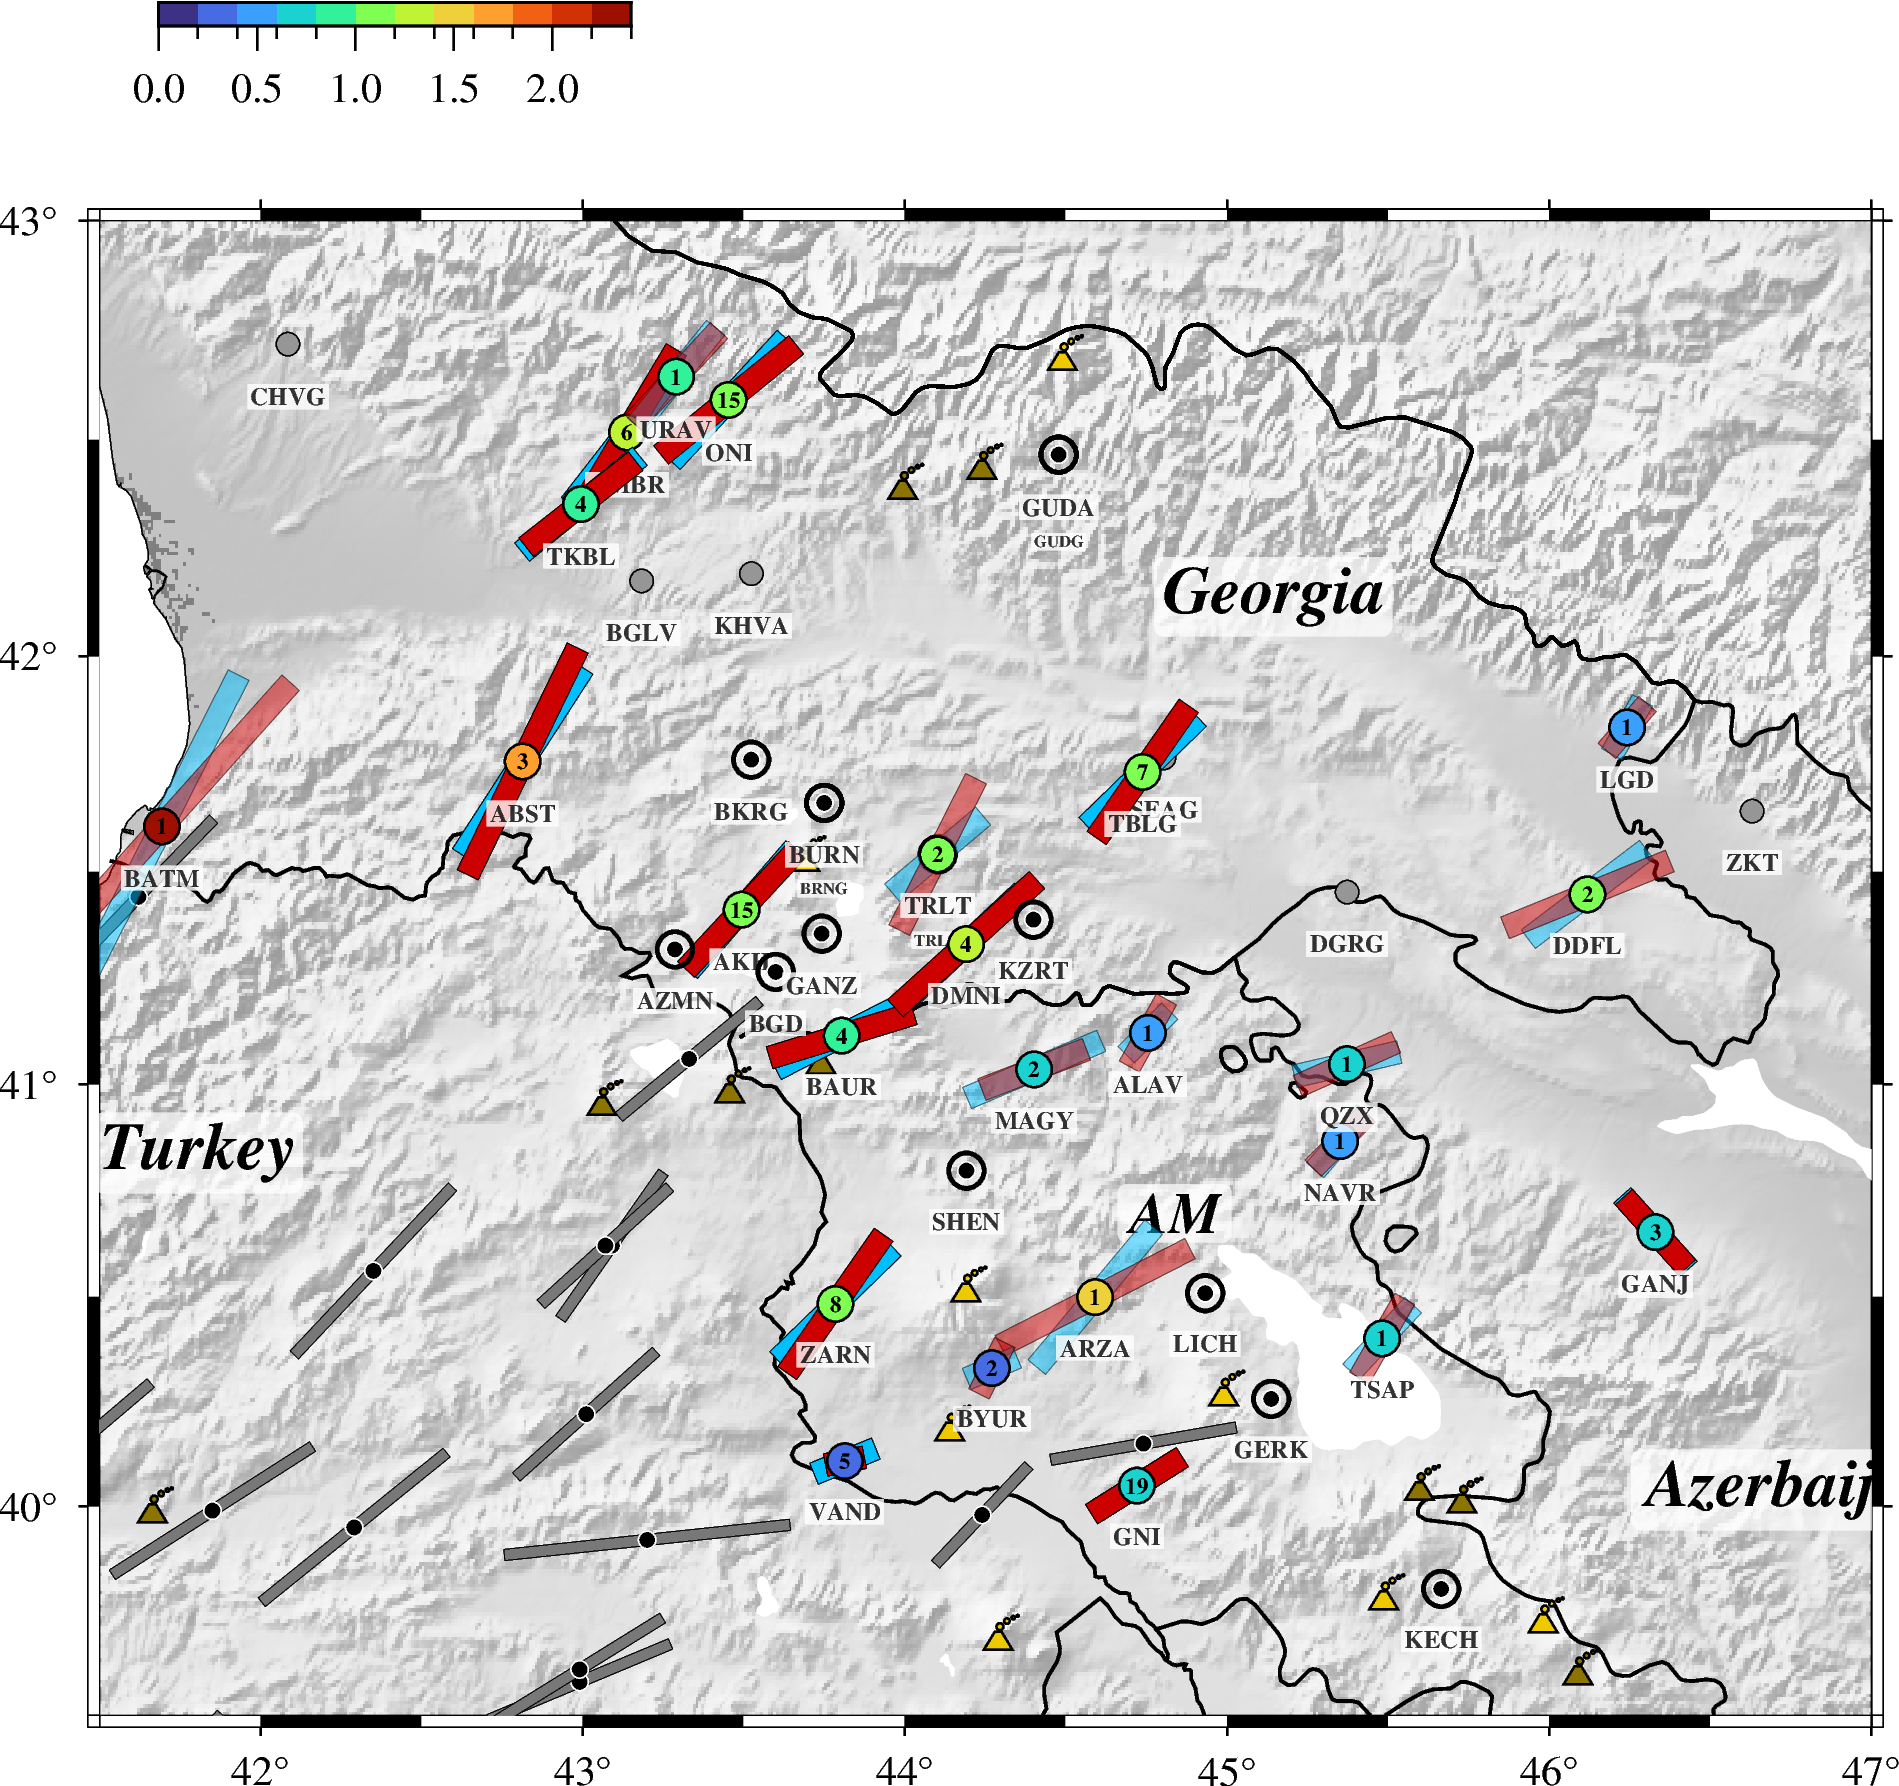

In [11]:
##==================for non-Null Good condition 
# Ori_Event = Event_clean()
# regvals = [39, 48, 37.5, 44.5]
regvals = [41.5, 47, 39.5, 43] ###Zoom in 
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals, Volcano=True, OtherSKS=True)

dv = pd.read_csv(Volcano)
for i in range(len(dv)):
    if dv['age'][i] == 'Pleistocene': color = 'gold4'
    else: color = 'gold2'
    figmap.plot(x=dv['lon'][i],y=dv['lat'][i],style='kvolcano/0.3c',color=color,pen='0.5p,black')
df = pd.read_csv(f'{Path}/{csvfile}')
for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    NET = values['network']; STA = values['station']
    st_lat = values['latitude']; st_lon = values['longitude']
    NetSta = f'{NET}.{STA}'
#     print(NetSta)
    df_ = df[df['Station']==NetSta]
    
    RCphi  = df_['RCphi'].values[0]
    RCdphi = df_['RCdphi'].values[0]
    RCdt   = df_['RCdt'].values[0]
    RCddt  = df_['RCddt'].values[0]
    SCphi  = df_['SCphi'].values[0]
    SCdphi = df_['SCphi'].values[0]
    SCdt   = df_['SCdt'].values[0]
    SCddt  = df_['SCddt'].values[0]
    nonNull= df_['nonNull'].values[0]
    Null   = df_['Null'].values[0]
    numSKS = df_['Number'].values[0]
    if nonNull > 0 :
        if nonNull<=2: t =50
        else: t = 0
        
        RCdata = [[st_lon, st_lat, RCphi-90, 6, RCdt*40]]
        figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.1p,black",transparency=t)   
        SCdata = [[st_lon, st_lat, SCphi-90, 6, SCdt*40]]
        figmap.plot(data=SCdata, style="J", color="red3", pen="0.1p,black",transparency=t) 
        figmap.plot(x=st_lon, y=st_lat,color= df_['SCdt'], style="c0.3c", pen="0.5p,black",cmap = 'cmapDT.cpt')
        figmap.text(x=st_lon,y=st_lat,text=nonNull, font="5.5p,Times-Bold,black")
    else:
        if numSKS >2: 
            figmap.plot(x=st_lon, y=st_lat, style="c0.15c",color='black', pen="white")
            figmap.plot(x=st_lon,y=st_lat,style="c0.3c", pen="1p,black")
        else: 
            figmap.plot(x=st_lon, y=st_lat, style="c0.2c",color='grey59', pen="black")
    if STA not in notplotLIST :
        figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="6p,Times-Bold,black",fill='white',transparency=20)
    else : 
        figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="4p,Times-Bold,black",fill='white',transparency=20)
# figmap.savefig(f'{SAVEpath}/{YearRange}/00_2Method_{YearRange}_v{ver}.pdf')
# figmap.savefig(f'{SAVEpath}/{YearRange}/00_2Method_{YearRange}_v{ver}.png',dpi=200)
figmap.show()

## RC 結果單獨畫

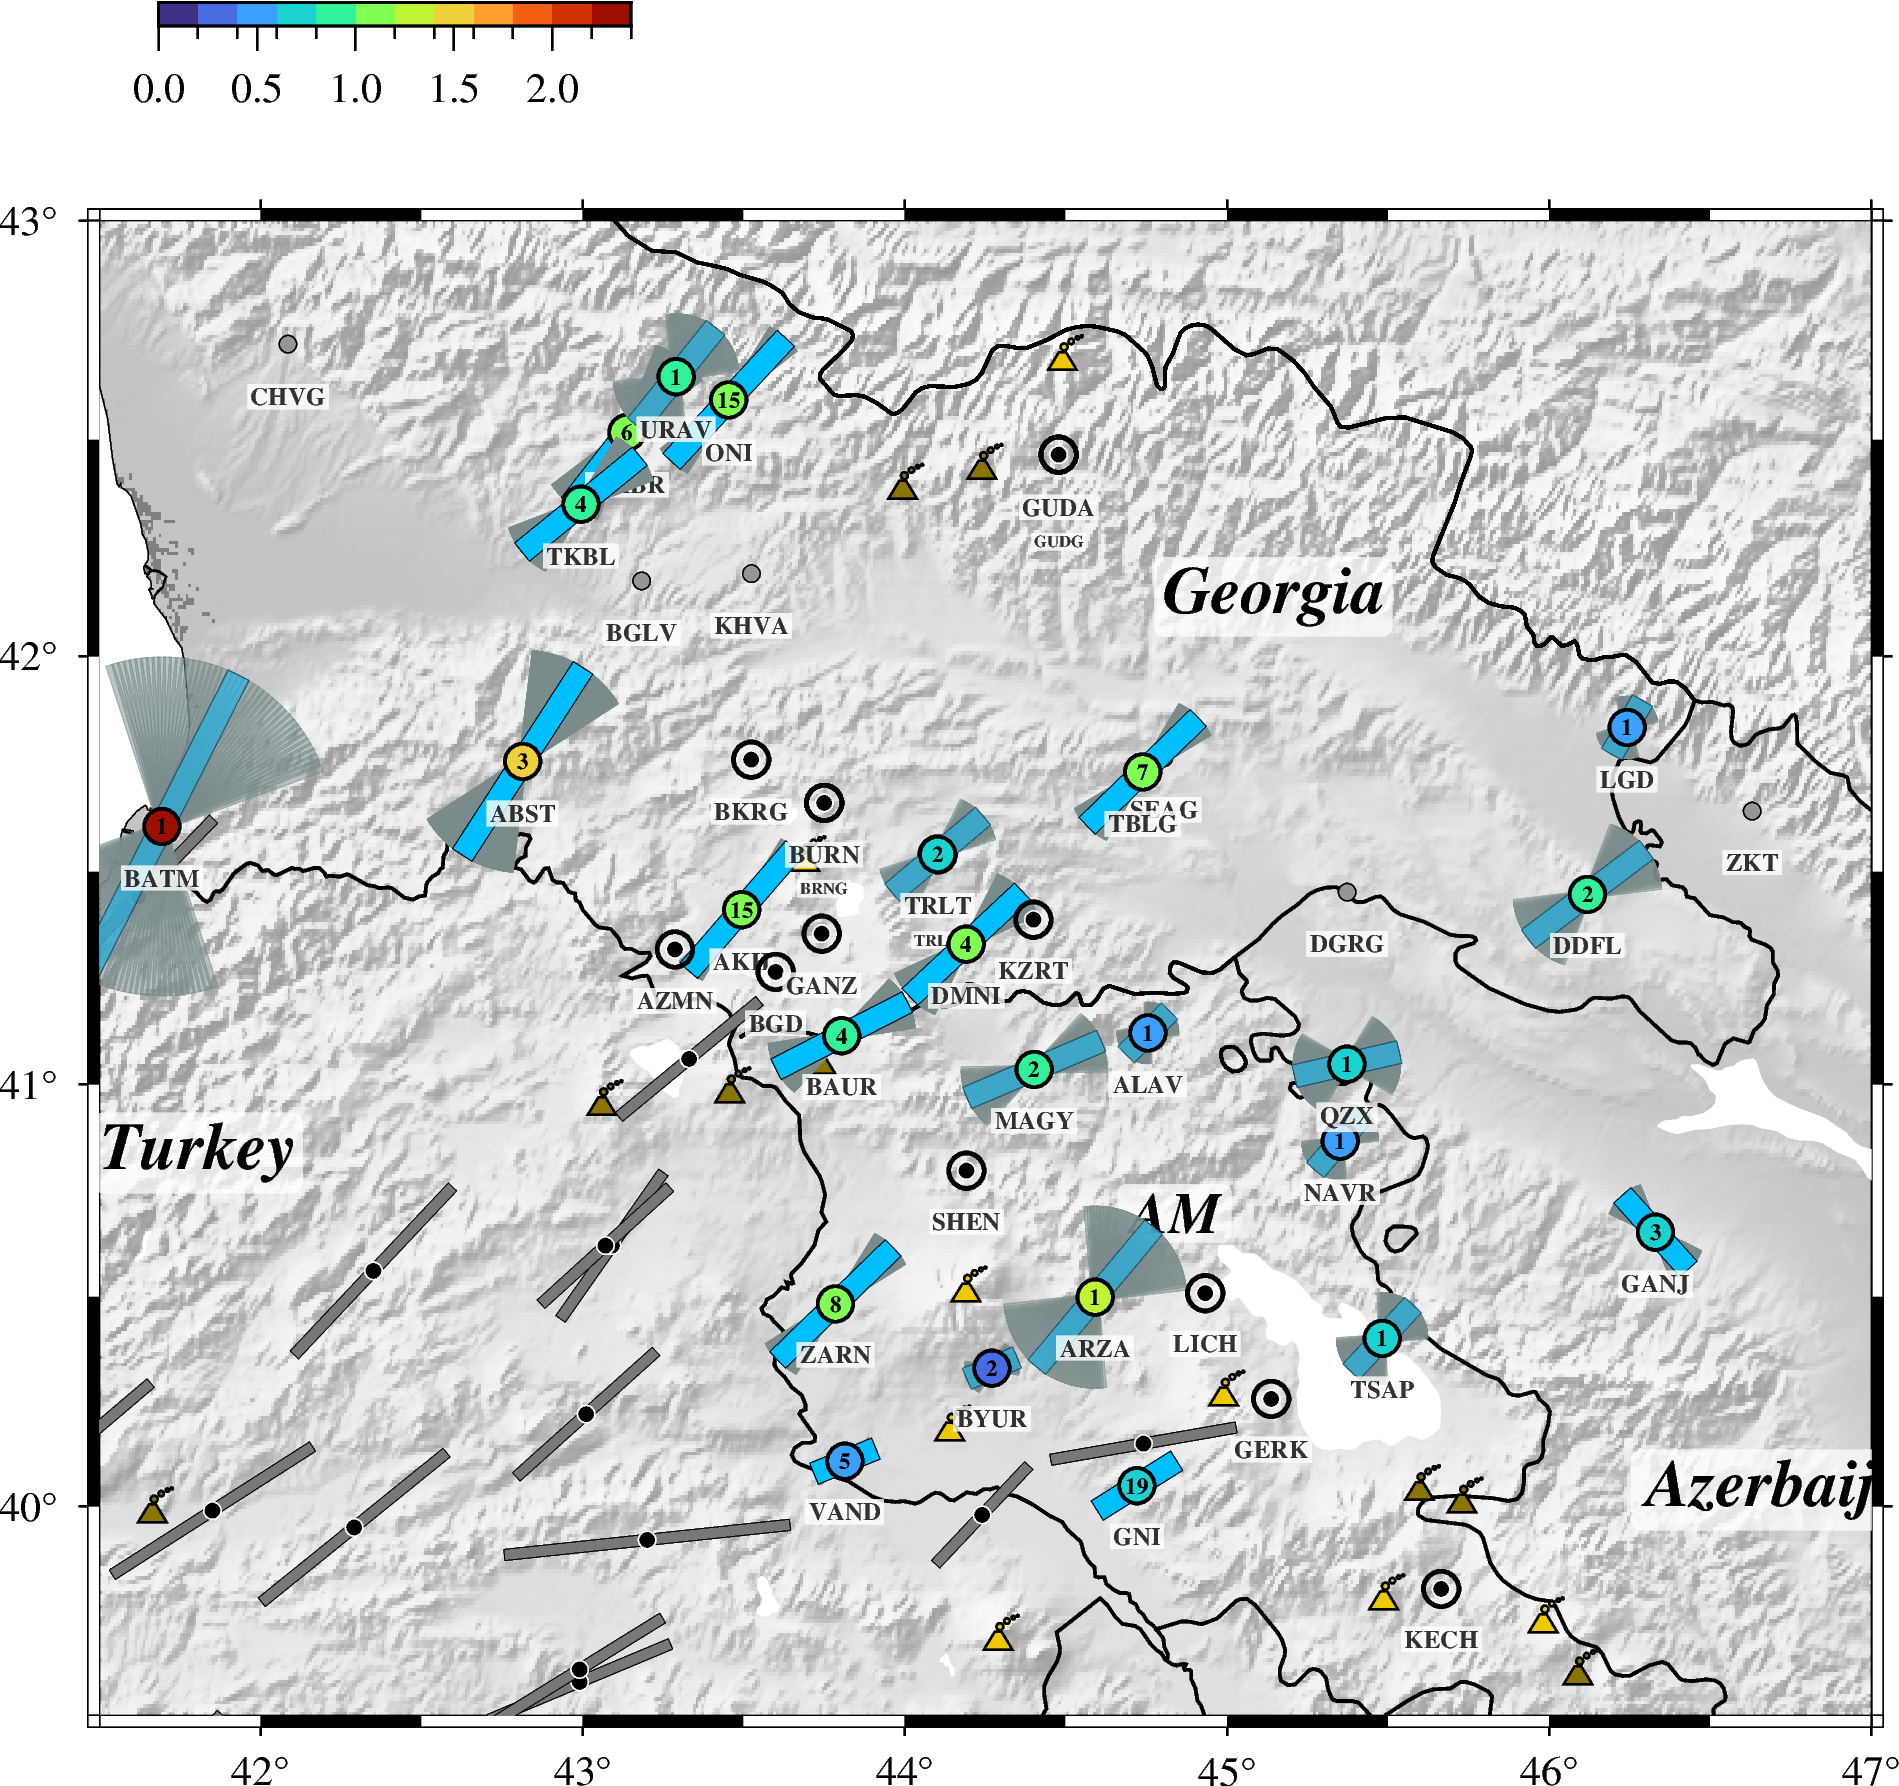

In [12]:
##==================for non-Null Good condition 
# Ori_Event = Event_clean()
# regvals = [39, 48, 37.5, 44.5]
regvals = [41.5, 47, 39.5, 43] ###Zoom in 
figmap = pygmt.Figure()
PygmtBegin(figmap, regvals,Volcano=False,OtherSKS=True)

dv = pd.read_csv(Volcano)
for i in range(len(dv)):
    if dv['age'][i] == 'Pleistocene': color = 'gold4'
    else: color = 'gold2'
    figmap.plot(x=dv['lon'][i],y=dv['lat'][i],style='kvolcano/0.3c',color=color,pen='0.5p,black')
    
df = pd.read_csv(f'{Path}/{csvfile}')
for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    NET = values['network']; STA = values['station']
    st_lat = values['latitude']; st_lon = values['longitude']
    NetSta = f'{NET}.{STA}'
#     print(NetSta)
    df_ = df[df['Station']==NetSta]
    
    RCphi  = df_['RCphi'].values[0]
    RCdphi = df_['RCdphi'].values[0]
    RCdt   = df_['RCdt'].values[0]
    RCddt  = df_['RCddt'].values[0]
    nonNull= df_['nonNull'].values[0]
    Null   = df_['Null'].values[0]    
    numSKS = df_['Number'].values[0]
    if np.isnan(RCphi) == False:
        if nonNull>2: t = 0
        else: t = 50
        for std in np.arange(-RCdphi,RCdphi,2):
            RCstd = RCphi+std
            error = [[st_lon, st_lat, RCstd-90, 2, RCdt*40]]
            figmap.plot(data=error, style="J", color="lightcyan4", pen="0.1p,lightcyan4", transparency=t )
        RCdata = [[st_lon, st_lat, RCphi-90, 6, RCdt*40]]

        figmap.plot(data=RCdata, style="J", color="deepskyblue1", pen="0.1p,black", transparency=t )   
        figmap.plot(x=st_lon, y=st_lat,color= df_['RCdt'], style="c0.3c", pen="0.8p,black",cmap = 'cmapDT.cpt')
        figmap.text(x=st_lon,y=st_lat,text=nonNull, font="5.5p,Times-Bold,black")  
    else: 
        if numSKS>2:
            figmap.plot(x=st_lon, y=st_lat, style="c0.15c",color='black', pen="white")
            figmap.plot(x=st_lon,y=st_lat,style="c0.3c", pen="1p,black")
        else:
            figmap.plot(x=st_lon, y=st_lat, style="c0.15c",color='grey59', pen="black")
    
    if STA not in notplotLIST :
        figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="6p,Times-Bold,black",fill='white',transparency=20)
    else : 
        figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="4p,Times-Bold,black",fill='white',transparency=20)

# figmap.savefig(f'{SAVEpath}/{YearRange}/01_RC_{YearRange}_v{ver}.pdf')
# figmap.savefig(f'{SAVEpath}/{YearRange}/01_RC_{YearRange}_v{ver}.png',dpi=200)         
figmap.show()

## SC 結果單獨畫

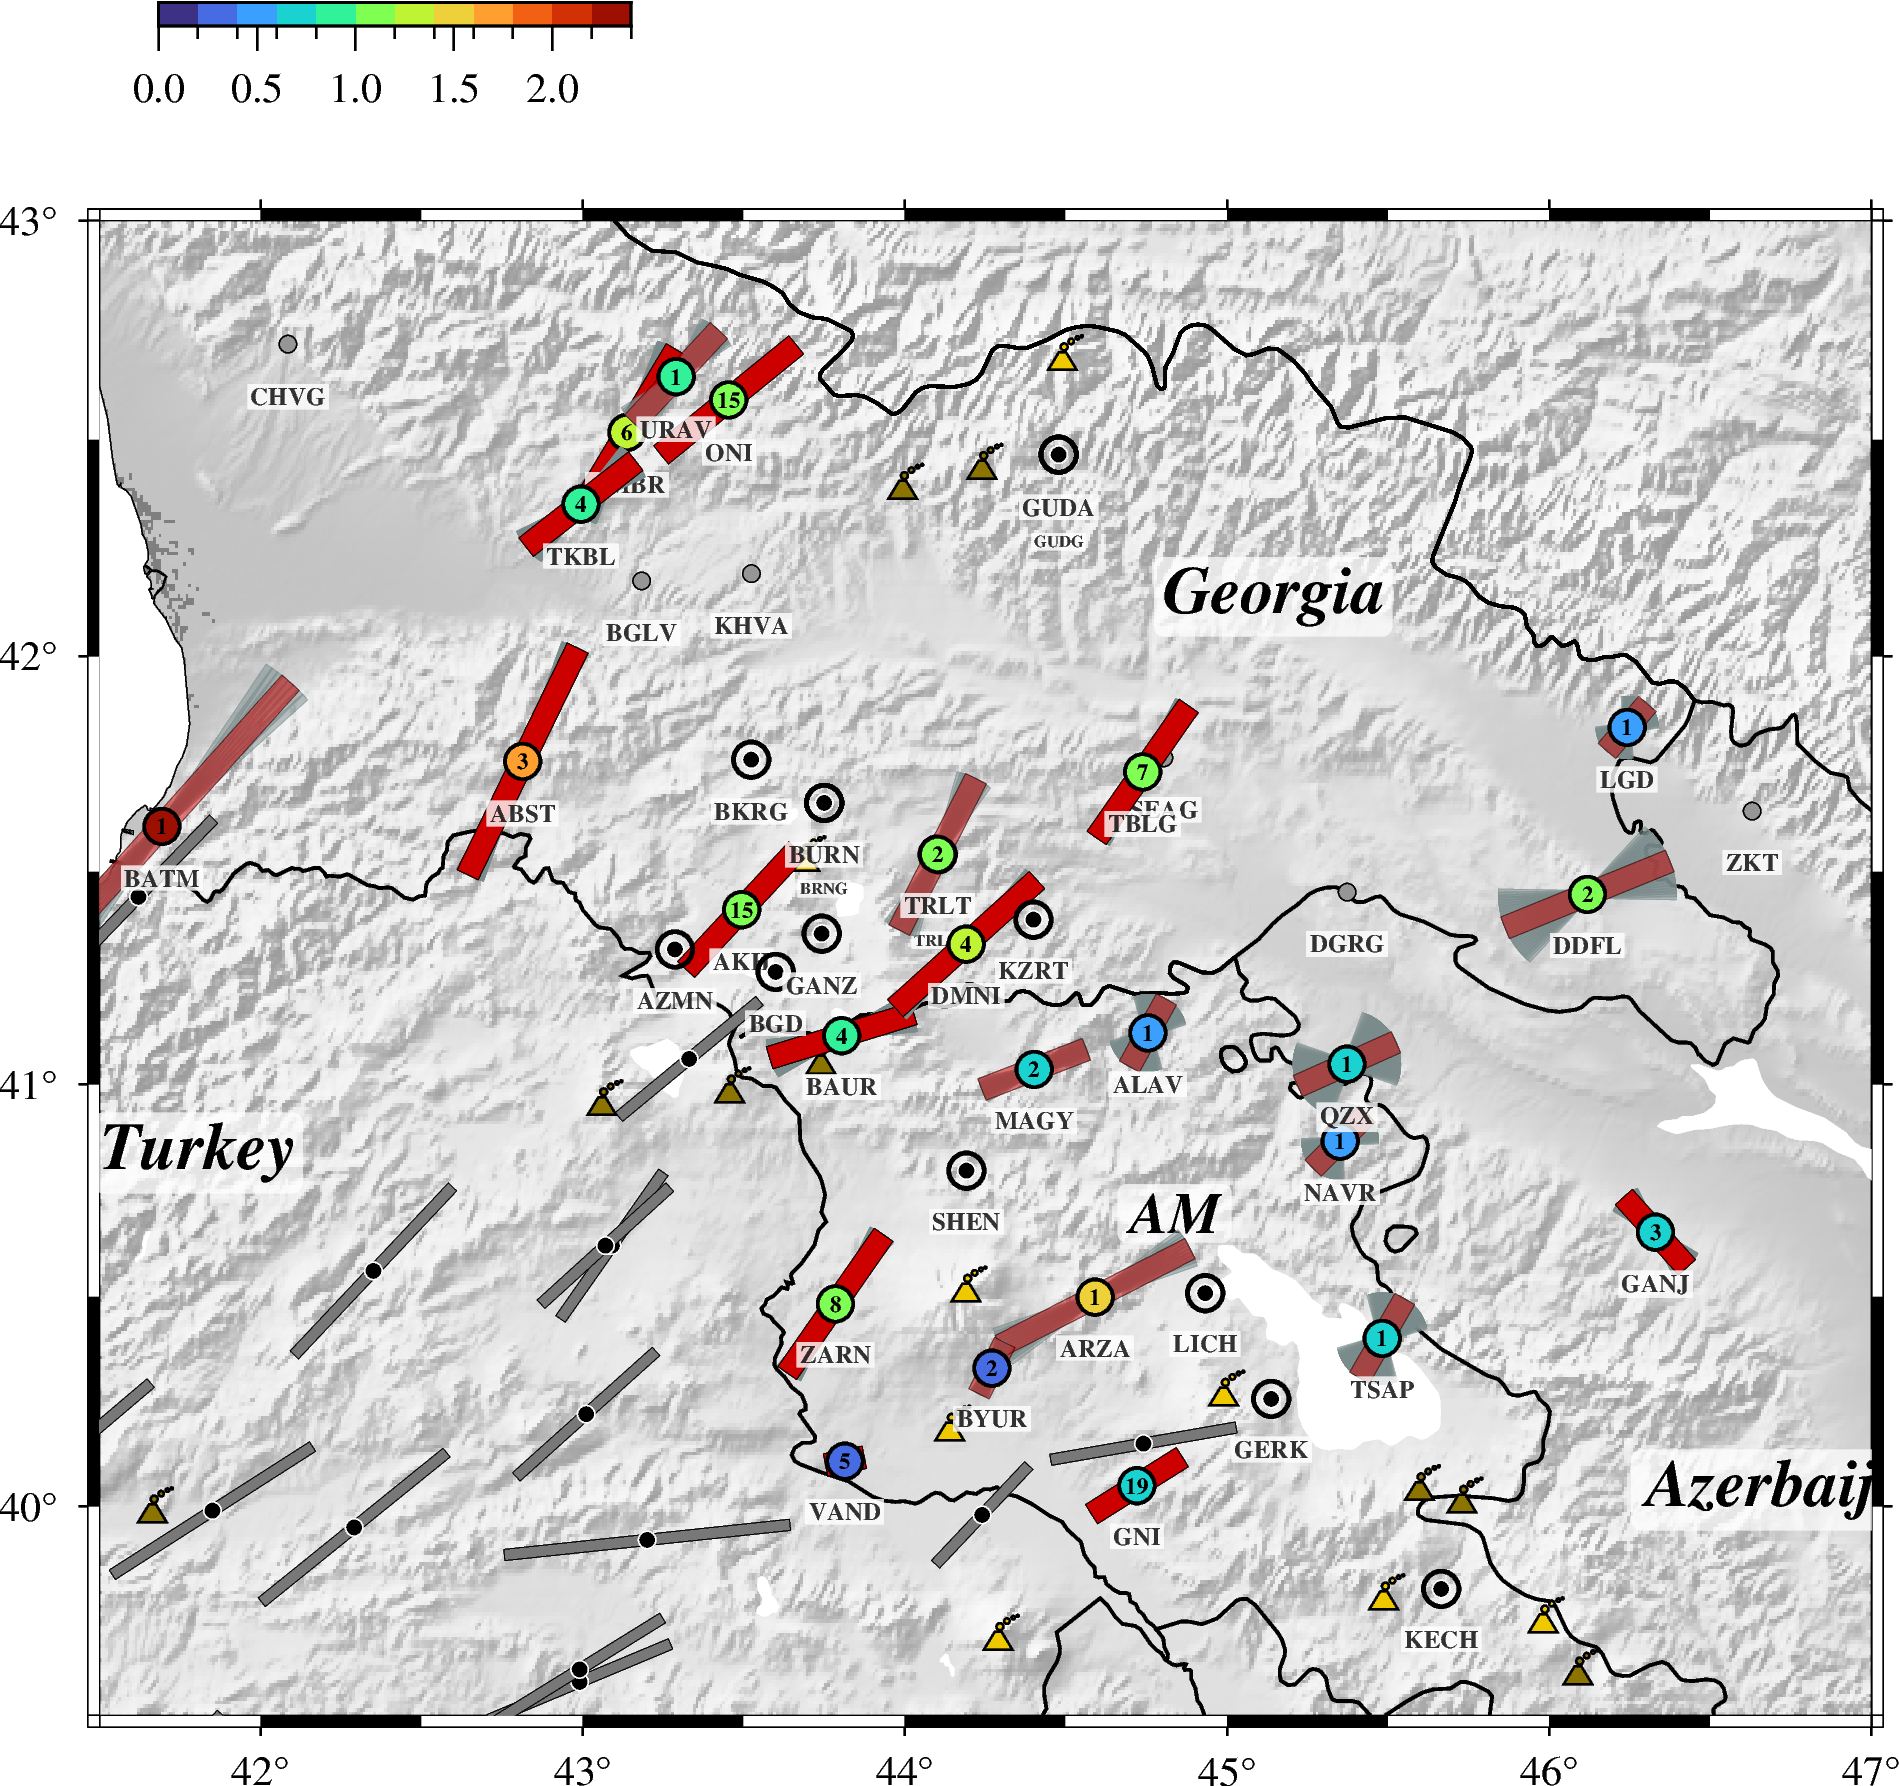

In [13]:
##==================for non-Null Good condition 
# Ori_Event = Event_clean()
# regvals = [39, 48, 37.5, 44.5]
regvals = [41.5, 47, 39.5,  43] ###Zoom in 
figmap = pygmt.Figure()

PygmtBegin(figmap, regvals, Volcano=False,OtherSKS=True)
dv = pd.read_csv(Volcano)
for i in range(len(dv)):
    if dv['age'][i] == 'Pleistocene': color = 'gold4'
    else: color = 'gold2'
    figmap.plot(x=dv['lon'][i],y=dv['lat'][i],style='kvolcano/0.3c',color=color,pen='0.5p,black')

df = pd.read_csv(f'{Path}/{csvfile}')
for STApath in glob.glob(f'{PKLpath}/*.pkl'):
    STApkl = pickle.load(open(STApath, "rb"))
    values = [value for keys, value in STApkl.items() ][0]
    
    NET = values['network']; STA = values['station']
    st_lat = values['latitude']; st_lon = values['longitude']
    NetSta = f'{NET}.{STA}'
#     print(NetSta)
    df_ = df[df['Station']==NetSta]
    
    SCphi  = df_['SCphi'].values[0]
    SCdphi = df_['SCdphi'].values[0]
    SCdt   = df_['SCdt'].values[0]
    SCddt  = df_['SCddt'].values[0]
    nonNull= df_['nonNull'].values[0]
    Null   = df_['Null'].values[0]
    numSKS = df_['Number'].values[0]
    if np.isnan(SCphi) == False:
        if nonNull>2: t = 0
        else: t = 50
        for std in np.arange(-SCdphi,SCdphi,2):
            SCstd = SCphi+std
            error = [[st_lon, st_lat, SCstd-90, 2, SCdt*40]]
            figmap.plot(data=error, style="J", color="lightcyan4", pen="0.1p,lightcyan4",transparency=t)
        SCdata = [[st_lon, st_lat, SCphi-90, 6, SCdt*40]]

        figmap.plot(data=SCdata, style="J", color="red3", pen="0.1p,black",transparency=t)   
        figmap.plot(x=st_lon, y=st_lat,color= df_['SCdt'], style="c0.3c", pen="0.8p,black",cmap = 'cmapDT.cpt')
        figmap.text(x=st_lon,y=st_lat,text=nonNull, font="5.5p,Times-Bold,black")      
    else: 
        if numSKS>2:
            figmap.plot(x=st_lon, y=st_lat, style="c0.15c",color='black', pen="white")
            figmap.plot(x=st_lon,y=st_lat,style="c0.3c", pen="1p,black")
        else:
            figmap.plot(x=st_lon, y=st_lat, style="c0.15c",color='grey59', pen="black")
    
    if STA not in notplotLIST :
        figmap.text(x=st_lon,y=st_lat-0.12,text=STA, font="6p,Times-Bold,black",fill='white',transparency=20)
    else : 
        figmap.text(x=st_lon,y=st_lat-0.2,text=STA, font="4p,Times-Bold,black",fill='white',transparency=20)
# figmap.savefig(f'{SAVEpath}/{YearRange}/02_SC_{YearRange}_v{ver}.pdf')
# figmap.savefig(f'{SAVEpath}/{YearRange}/02_SC_{YearRange}_v{ver}.png',dpi=200)          
figmap.show()

## ------------- make dt cpt

In [ ]:
pygmt.makecpt(cmap = 'turbo', 
              reverse = False, 
              series = [0, 2.4, 0.2], 
              output = 'cmapDT.cpt', 
              continuous = False,  
              M = True)